In [1]:
# importing data and auxiliar functions

import saopaulo.sp_grid as gr
import bikescience.distributions as dist
import saopaulo.cycling_potential as cp
import saopaulo.choropleth_folium as choro_folium
import saopaulo.choropleth as choro
from bikescience.slope import plot_slope, plot_slopes, split_route
from shapely.geometry import LineString
import ast
from numpy import nan

import folium
import pandas as pd
import geopandas as gpd
from ipywidgets import interact_manual, widgets, fixed
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import warnings
import numpy as np
warnings.simplefilter('ignore')

/home/pedro/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
#read data

zone_shp = gpd.read_file('../data/sao-paulo/od/shapes/Zonas_2017_region.shp')
zone_shp.crs = {'init': 'epsg:31983'}  
zone_shp.to_crs(epsg='4326', inplace=True)

# read routes files and join with general trips file
od_trips = pd.read_csv('bases/complete_csv.csv')
# fix FE_VIA with wrong format (because of thousand separator)
od_trips.loc[od_trips['FE_VIA'] >= 10000, 'FE_VIA'] = od_trips.loc[od_trips['FE_VIA'] >= 10000, 'FE_VIA'] / 1000

od_trips.set_index('ID_ORDEM', inplace=True, drop=False)

od_trips.dropna(inplace = True)

the_grid = gr.create(n=9, west_offset=-0.15, east_offset=0.23, north_offset=0.19, south_offset=-0.46)

In [3]:
display(od_trips)

,orig_lat,orig_lon,dest_lat,dest_lon,route,ZONA,MUNI_DOM,CO_DOM_X,CO_DOM_Y,ID_DOM,...,VIA_BICI,TP_ESTBICI,ID_ORDEM,length,modal,id,distance_potential,age_potential,inclination_potential,final_potential
ID_ORDEM,,,,,,,,,,,,,,,,,,,,,
1.0,-23.551678,-46.628858,-23.551495,-46.635115,"[[-46.628827, -23.55186, 748.52], [-46.627845,...",1.0,36.0,333743.0,7394463.0,10001.0,...,0.0,0.0,1.0,1849.286293,pedestrian,1.0,0.650491,0.023107,0.206501,0.293366
2.0,-23.551495,-46.635115,-23.551678,-46.628858,"[[-46.635147, -23.551546, 783.14], [-46.635381...",1.0,36.0,333743.0,7394463.0,10001.0,...,0.0,0.0,2.0,1760.427711,pedestrian,2.0,0.689523,0.023107,0.463706,0.392112
3.0,-23.551678,-46.628858,-23.571829,-46.690238,"[[-46.628827, -23.55186, 748.52], [-46.627845,...",1.0,36.0,333743.0,7394463.0,10001.0,...,0.0,0.0,3.0,9473.535456,subway,3.0,0.032389,0.848482,0.066909,0.315927
4.0,-23.571829,-46.690238,-23.525949,-46.666559,"[[-46.690264, -23.571842, 742.26], [-46.691246...",1.0,36.0,333743.0,7394463.0,10001.0,...,0.0,0.0,4.0,6428.546731,subway,4.0,0.077287,0.848482,0.402769,0.442846
4.0,-23.525949,-46.666559,-23.537903,-46.670921,"[[-46.666835, -23.525929, 733.11], [-46.666934...",1.0,36.0,333743.0,7394463.0,10001.0,...,0.0,0.0,4.0,2667.571706,bus_sp,4.0,0.391186,0.848482,0.280026,0.506565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183088.0,-23.401886,-47.008661,-23.402259,-47.009811,"[[-47.008662, -23.401916, 698.15], [-47.008789...",517.0,25.0,294618.0,7410518.0,5171418.0,...,0.0,0.0,183088.0,131.295991,pedestrian,183088.0,0.128145,0.323018,0.843343,0.431502
183089.0,-23.393870,-47.003570,-23.398719,-47.002822,"[[-47.00353, -23.393732, 699.83], [-47.00367, ...",517.0,25.0,295243.0,7411456.0,5171599.0,...,0.0,0.0,183089.0,816.655729,pedestrian,183089.0,0.905531,0.720850,0.638682,0.755021
183090.0,-23.398719,-47.002822,-23.393870,-47.003570,"[[-47.002834, -23.398807, 679.54], [-47.002995...",517.0,25.0,295243.0,7411456.0,5171599.0,...,0.0,0.0,183090.0,752.109085,pedestrian,183090.0,0.826529,0.720850,0.441549,0.662976


In [3]:
od_trips = gpd.GeoDataFrame(od_trips, crs={'init': 'epsg:4326'},
                 geometry=[LineString(eval(r)) for r in od_trips['route']])

In [76]:
bike_routes = gpd.read_file('../data/sao-paulo/od/routes/bike_routes_all.shp')
bike_routes.crs = {'init': 'epsg:4326'}
bike_routes['length'] = bike_routes['geometry'].length * 100000
cp_list = []
for i, r in bike_routes.iterrows():
    try:
        pot_d, pot_a, pot_i = cp.cycling_potential_variables(r)
        cp_list.append(['bike', r['ID_ORDEM'], 
                        pot_d, pot_a, pot_i, 
                        (pot_i + pot_a + pot_d) / 3, 
                        r['FE_VIA'], r['MUNI_O']])
    except:
        pass
columns = ['modal', 'trip_id', 'distance_potential', 'age_potential', 
           'inclination_potential', 'final_potential','FE_VIA', 'Muni']
bike_trips = pd.DataFrame(data = cp_list, columns = columns)

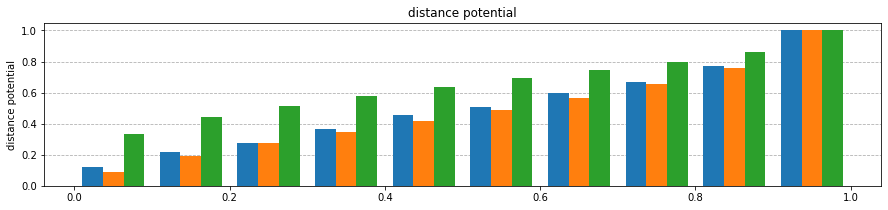

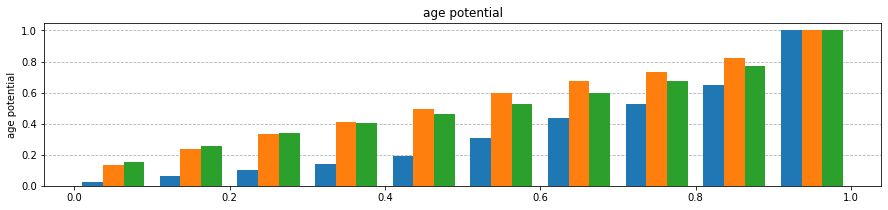

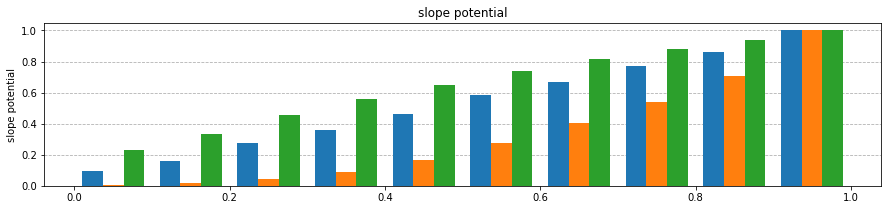

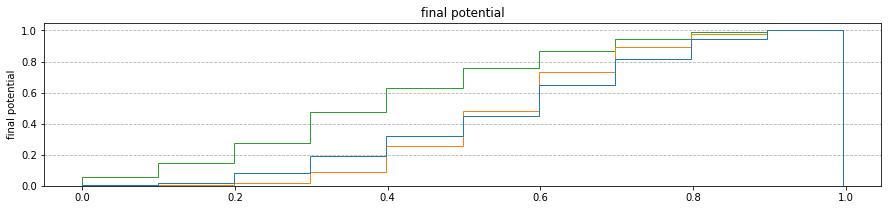

In [32]:
plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist([bike_trips['distance_potential'],
             od_trips.loc[od_trips['modal'] == 'pedestrian']['distance_potential'],
             od_trips.loc[od_trips['modal'] == 'car']['distance_potential']],
            weights = 
            [bike_trips['FE_VIA'],
             od_trips.loc[od_trips['modal'] == 'pedestrian']['FE_VIA'],
             od_trips.loc[od_trips['modal'] == 'car']['FE_VIA']], 
         density = True, cumulative = 1)
#plt.xticks([1, 2, 3], ['cycling', 'walking', 'car'])
plt.title('distance potential')
plt.ylabel('distance potential')
plt.show()

plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist([bike_trips['age_potential'],
             od_trips.loc[od_trips['modal'] == 'pedestrian']['age_potential'],
             od_trips.loc[od_trips['modal'] == 'car']['age_potential']],
            weights = 
            [bike_trips['FE_VIA'],
             od_trips.loc[od_trips['modal'] == 'pedestrian']['FE_VIA'],
             od_trips.loc[od_trips['modal'] == 'car']['FE_VIA']], 
         density = True, cumulative = 1)
#plt.xticks([1, 2, 3], ['cycling', 'walking', 'car'])
plt.title('age potential')
plt.ylabel('age potential')
plt.show()

plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist([bike_trips['inclination_potential'],
             od_trips.loc[od_trips['modal'] == 'pedestrian']['inclination_potential'],
             od_trips.loc[od_trips['modal'] == 'car']['inclination_potential']],
            weights = 
            [bike_trips['FE_VIA'],
             od_trips.loc[od_trips['modal'] == 'pedestrian']['FE_VIA'],
             od_trips.loc[od_trips['modal'] == 'car']['FE_VIA']], 
         density = True, cumulative = 1)
#plt.xticks([1, 2, 3], ['cycling', 'walking', 'car'])
plt.title('slope potential')
plt.ylabel('slope potential')
plt.show()

plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = 10,
         x = [bike_trips['final_potential'],
             od_trips.loc[od_trips['modal'] == 'pedestrian']['final_potential'],
             od_trips.loc[od_trips['modal'] == 'car']['final_potential']],
         weights = 
            [bike_trips['FE_VIA'],
             od_trips.loc[od_trips['modal'] == 'pedestrian']['FE_VIA'],
             od_trips.loc[od_trips['modal'] == 'car']['FE_VIA']], 
         density = True, histtype='step', cumulative = 1,
        label = ['cycling', 'walking', 'car'])
#plt.xticks([1, 2, 3], ['cycling', 'walking', 'car'])
plt.title('final potential')
plt.ylabel('final potential')
plt.show()

In [78]:
def print_boxplot_limits(variable, data_modals, modals_name, step = 25):
    column = variable + '_potential'
    
    for i in range(len(data_modals)):
        modal = data_modals[i]
        print('-------------------------', modals_name[i])
        y, x = (np.histogram(modal[column], 
                             bins = 100, 
                             weights = modal['FE_VIA'], 
                             density = True))
        total = quarter = 0
        for i in range(len(y)):
            perc = round(y[i] * (x[i+1] - x[i]) * 100, 2)
            total += perc
            if total >= quarter - 0.5:
                quarter += step
                print(round(x[i], 3), '-',
                      round(x[i + 1], 3), ':\t', 
                      perc, '%\t\t', round(total), '%')

In [81]:
print_boxplot_limits('final', 
                     [bike_trips.loc[bike_trips['Muni'] == 36], 
                      od_trips.loc[od_trips['modal'] == 'pedestrian'], 
                      od_trips.loc[od_trips['modal'] == 'car']],
                     ['cycling', 'walking', 'car'],
                    5)

------------------------- cycling
0.042 - 0.052 :	 0.05 %		 0 %
0.261 - 0.271 :	 0.15 %		 5 %
0.328 - 0.337 :	 0.18 %		 10 %
0.356 - 0.366 :	 1.33 %		 15 %
0.394 - 0.404 :	 1.69 %		 20 %
0.442 - 0.451 :	 2.26 %		 27 %
0.49 - 0.499 :	 0.75 %		 30 %
0.537 - 0.547 :	 1.21 %		 36 %
0.575 - 0.585 :	 1.71 %		 40 %
0.623 - 0.632 :	 2.06 %		 46 %
0.651 - 0.661 :	 3.85 %		 53 %
0.661 - 0.67 :	 2.17 %		 55 %
0.689 - 0.699 :	 1.88 %		 61 %
0.708 - 0.718 :	 2.26 %		 65 %
0.737 - 0.746 :	 1.94 %		 71 %
0.775 - 0.785 :	 2.16 %		 76 %
0.813 - 0.823 :	 2.74 %		 82 %
0.842 - 0.851 :	 2.24 %		 86 %
0.851 - 0.861 :	 3.8 %		 90 %
0.908 - 0.918 :	 1.69 %		 95 %
0.956 - 0.965 :	 0.64 %		 100 %
------------------------- walking
0.0 - 0.01 :	 0.05 %		 0 %
0.349 - 0.359 :	 0.91 %		 5 %
0.399 - 0.409 :	 1.29 %		 10 %
0.429 - 0.439 :	 1.43 %		 15 %
0.458 - 0.468 :	 1.73 %		 20 %
0.488 - 0.498 :	 2.05 %		 25 %
0.518 - 0.528 :	 2.11 %		 32 %
0.538 - 0.548 :	 2.56 %		 36 %
0.558 - 0.568 :	 2.26 %		 41 %
0.578 - 0.5

In [8]:
def set_start_end_zones(trips, zones):
    
    start_zones = []
    end_zones = []
    
    total = len(trips)
    perc = 0
    
    for i, trip in trips.iterrows():
        print ('aaa')
        """
        start, end = trip['geometry'].boundary
        print ('bbb')
        
        print ('ccc')
        for _, zone in zones.iterrows():
            if (zone['geometry'].contains(start)):
                start_zones.append(zone['NumeroZona'])
                break
                
        print ('ddd')
        for _, zone in zones.iterrows():
            if (zone['geometry'].contains(end)):
                end_zones.append(zone['NumeroZona'])
                break
        print ('eee')
                
        if i >= perc * total:
            perc += 0.1
            print (perc * 100, '%')
        """
        break
        
        
    #trips['start_zone'] = start_zones
    #trips['end_zone'] = end_zones
        
#set_start_end_zones (od_trips, zone_shp)

#display(od_trips['start_zone'])

In [9]:
def calculate_trips_zone_intersection (trips, zones):
    
    trips_geometries = list(trips['geometry'])
    trips_expansion = list(trips['FE_VIA'])

    trips_per_zone = [0]*517 # hash to store trips indexed by zones

    progress = 0
    
    for z in range(len(zones)):
        zone = zones.iloc[z]['geometry']
        
        if z / len(zones) >= progress:
            print (round(progress * 100), '%')
            progress += 0.1
            
        for i in range (len (trips_geometries)):

            if (trips_geometries[i].intersects(zone)):
                trips_per_zone[z] += trips_expansion[i]
            
    return trips_per_zone   

def calculate_trips_mean_pot_intersection (trips, zones, potential_label, pot_as_prob = False):
    
    trips_geometries = list(trips['geometry'])
    trips_expansion = list(trips['FE_VIA'])
    trips_potential = list(trips[potential_label])

    total_per_zone = [0]*517 # hash to store trips indexed by zones

    progress = 0
    
    for z in range(len(zones)):
        total_trips = 0
        zone = zones.iloc[z]['geometry']
        
        if z / len(zones) >= progress:
            print (round(progress * 100), '%')
            progress += 0.1
            
        for i in range (len (trips_geometries)):

            if (trips_geometries[i].intersects(zone)):
                total_per_zone[z] += trips_expansion[i] * trips_potential[i]
                total_trips += trips_expansion[i]
        
        if not pot_as_prob:
            total_per_zone[z] = 0 if total_trips == 0 else total_per_zone[z] / total_trips
            
    return total_per_zone    


def plot_trips_per_zone_intersection (trips, zones):
    aux = calculate_trips_zone_intersection(trips, zone_shp)
    zone_shp['intersect_trips'] = aux


    tooltip_columns = ['NomeZona', 'intersect_trips']
    tooltip_aliases = ['Zone', 'Trips']
    fmap = gr.map_around_sp(the_grid=None,zoom=10,plot_grid=False)
    choro_folium.plot_choropleth(fmap, 'Trips per zone', 
                                 'YlOrBr', lambda x : x['intersect_trips'], 
                          zone_shp.loc[zone_shp['NumeroMuni']==36], tooltip_columns, tooltip_aliases)
    

In [10]:
def filter_potential_widgets(btn_text, process_function):
    
    width = '200px'
    layout = widgets.Layout(width = '500px')
    
    im = interact_manual(
        process_function,
        final_potential = widgets.FloatRangeSlider(
            value=[0.85, +1.],
            min=0, max=1., step=0.05,
            description='Final Potential:\t',
            style={'description_width': width},
            layout=layout
        ),
        distance_potential = widgets.FloatRangeSlider(
            value=[0, +1.],
            min=0, max=1., step=0.05,
            description='Distance Potential:\t',
            style={'description_width': width},
            layout=layout
        ),
        inclination_potential = widgets.FloatRangeSlider(
            value=[0, +1.],
            min=0, max=1., step=0.05,
            description='Inclination Potential:\t',
            style={'description_width': width},
            layout=layout
        ),
        age_potential = widgets.FloatRangeSlider(
            value=[0, +1.],
            min=0, max=1., step=0.05,
            description='Age Potential:\t',
            style={'description_width': width},
            layout=layout
        ),
        reference = widgets.Dropdown(options = [('Whole Trip', 'intersect'),('Origin', 'ZONA_O'), 
                                                ('Destination', 'ZONA_D')],
                                     description = 'Trip Reference Point:\t', 
                                     style={'description_width': width}),
        
        modal = widgets.Dropdown(options = [('All', None), ('Car', 'car'), ('Subway', 'subway'),
                                            ('Pedestrian', 'pedestrian'), ('Motorcycle', 'motorcycle'),
                                            ('Train', 'train')],
                                 description = 'Modal', 
                                 style={'description_width': width})
    )
    im.widget.children[8].description = btn_text
    
def inside_limits (limits, value):
    return value >= limits[0] and value <= limits[1]
    
def filter_potential(final_potential, distance_potential, age_potential, inclination_potential, modal):
    if modal != None:
        print(modal)
        aux = od_trips.loc[od_trips['modal'] == modal]
    else:
        aux = od_trips
    
    aux = aux.loc[aux['age_potential'] >= age_potential[0]]
    aux = aux.loc[aux['age_potential'] <= age_potential[1]]
    aux = aux.loc[aux['distance_potential'] >= distance_potential[0]]
    aux = aux.loc[aux['distance_potential'] <= distance_potential[1]]
    aux = aux.loc[aux['inclination_potential'] >= inclination_potential[0]]
    aux = aux.loc[aux['inclination_potential'] <= inclination_potential[1]]
    aux = aux.loc[aux['final_potential'] >= final_potential[0]]
    aux = aux.loc[aux['final_potential'] <= final_potential[1]]
    return aux

In [11]:
def plot_potential_trips_per_zone(final_potential, distance_potential, age_potential, 
                                  inclination_potential, reference, modal, debug=False, only_sp = True):
    df = filter_potential(final_potential, distance_potential, age_potential, inclination_potential, modal)
    
    zones = zone_shp.loc[zone_shp["NumeroMuni"] == 36] if only_sp else zone_shp
    
    if (reference == 'intersect'):
        trips_per_zone = calculate_trips_zone_intersection(df, zones)
    else:
        trips_per_zone = [0]*517
        for i, t in df.iterrows():
            trips_per_zone[int(t[reference] - 1)] += t['FE_VIA']

    zone_shp['potential_trips'] = trips_per_zone
    zones = zone_shp.loc[zone_shp["NumeroMuni"] == 36] if only_sp else zone_shp

    tooltip_columns = ['NomeZona', 'potential_trips']
    tooltip_aliases = ['Zone', 'Potential Trips']
    fmap = gr.map_around_sp(the_grid=None,zoom=10,plot_grid=False)
    choro_folium.plot_choropleth(fmap, 'Trips per zone', 'YlOrBr', lambda x : x['potential_trips'], 
                          zones, tooltip_columns, tooltip_aliases)
    
    if debug:
        #display(df)
        plot_slopes (fmap, df['geometry'], 1000, False)
    
    display(fmap)


In [12]:
filter_potential_widgets('Filter trips', plot_potential_trips_per_zone)

interactive(children=(FloatRangeSlider(value=(0.85, 1.0), description='Final Potential:\t', layout=Layout(widt…

In [13]:
def plot_potential_mean_widgets():
    im = interact_manual(
        plot_potential_mean,
        variable = widgets.Dropdown(options = [('Final', 'final_potential'), 
                                               ('Distance', 'distance_potential'), 
                                               ('Age', 'age_potential'), 
                                               ('Inclination', 'inclination_potential')],
                                    description = 'Potential Variable', 
                                    style={'description_width': '300px'},
                                    layout = widgets.Layout(width = '500px')),
        reference = widgets.Dropdown(options = [('Origin', 'ZONA_O'), ('Destination', 'ZONA_D'), 
                                                ('Whole Trip', 'intersect')],
                                     description = 'Trip Reference Point:\t', 
                                    style={'description_width': '300px'},
                                    layout = widgets.Layout(width = '500px')),
        
        modal = widgets.Dropdown(options = [('All', None), ('Car', 'car'), ('Subway', 'subway'),
                                            ('Pedestrian', 'pedestrian'), ('Motorcycle', 'motorcycle'),
                                            ('Train', 'train')],
                                 description = 'Modal', 
                                    style={'description_width': '300px'},
                                    layout = widgets.Layout(width = '500px'))
    )
    im.widget.children[4].description = 'Plot Map'
    
def plot_potential_mean(variable, reference, modal, only_sp = True):
    trips = [0]*517
    potential = [0]*517
    
    zones = zone_shp.loc[zone_shp["NumeroMuni"] == 36] if only_sp else zone_shp

    if modal != None:
        aux = od_trips.loc[od_trips['modal'] == modal]
    else:
        aux = od_trips
        
    if reference == 'intersect':
        mean = calculate_trips_mean_pot_intersection(aux, 
                                                    zones, variable)
    else:
        for i, t in aux.iterrows():
            potential[int(t[reference] - 1)] += t[variable] * t['FE_VIA']
            trips[int(t[reference] - 1)] += t['FE_VIA']

        mean = [0 if trips[i] == 0 else potential[i] / trips [i] for i in range(517)]
    
    zone_shp['mean_potential'] = mean
    zones = zone_shp.loc[zone_shp["NumeroMuni"] == 36] if only_sp else zone_shp

    tooltip_columns = ['NomeZona', 'mean_potential']
    tooltip_aliases = ['Zone', 'Mean Potential (' + reference + ')']
    fmap = gr.map_around_sp(the_grid=None,zoom=10,plot_grid=False)
    choro_folium.plot_choropleth(fmap, 'Mean Potential (' + reference + ') ' + ' (' + variable + ')', 
                                 'YlOrBr', lambda x : x['mean_potential'], 
                          zones, tooltip_columns, tooltip_aliases)
    display(fmap)

In [14]:
plot_potential_mean_widgets()

interactive(children=(Dropdown(description='Potential Variable', layout=Layout(width='500px'), options=(('Fina…

In [15]:
def plot_potential_prob_widgets():
    im = interact_manual(
        plot_potential_prob,
        variable = widgets.Dropdown(options = [('Final', 'final_potential'), 
                                               ('Distance', 'distance_potential'), 
                                               ('Age', 'age_potential'), 
                                               ('Inclination', 'inclination_potential')],
                                    description = 'Potential Variable', 
                                    style={'description_width': '300px'},
                                    layout = widgets.Layout(width = '500px')),
        reference = widgets.Dropdown(options = [('Origin', 'ZONA_O'), ('Destination', 'ZONA_D'), 
                                                ('Whole Trip', 'intersect')],
                                     description = 'Trip Reference Point:\t', 
                                    style={'description_width': '300px'},
                                    layout = widgets.Layout(width = '500px')),
        
        modal = widgets.Dropdown(options = [('All', None), ('Car', 'car'), ('Subway', 'subway'),
                                            ('Pedestrian', 'pedestrian'), ('Motorcycle', 'motorcycle'),
                                            ('Train', 'train')],
                                 description = 'Modal', 
                                    style={'description_width': '300px'},
                                    layout = widgets.Layout(width = '500px'))
    )
    im.widget.children[4].description = 'Plot Map'
    
def plot_potential_prob(variable, reference, modal, only_sp = True):
    trips = [0]*517
    potential = [0]*517
    
    zones = zone_shp.loc[zone_shp["NumeroMuni"] == 36] if only_sp else zone_shp

    if modal != None:
        aux = od_trips.loc[od_trips['modal'] == modal]
    else:
        aux = od_trips
        
    if reference == 'intersect':
        potential = calculate_trips_mean_pot_intersection(aux, 
                                                    zones, variable, True)
    else:
        for i, t in aux.iterrows():
            potential[int(t[reference] - 1)] += t[variable] * t['FE_VIA']
    
    zone_shp['mean_potential'] = potential
    zones = zone_shp.loc[zone_shp["NumeroMuni"] == 36] if only_sp else zone_shp

    tooltip_columns = ['NomeZona', 'mean_potential']
    tooltip_aliases = ['Zone', 'Mean Potential (' + reference + ')']
    fmap = gr.map_around_sp(the_grid=None,zoom=10,plot_grid=False)
    choro_folium.plot_choropleth(fmap, 'Mean Potential (' + reference + ') ' + ' (' + variable + ')', 
                                 'YlOrBr', lambda x : x['mean_potential'], 
                          zones, tooltip_columns, tooltip_aliases)
    display(fmap)

In [16]:
# total of cyclable trips 
# considering the potential as the percentual of trips to be converted
# (0.3 potential, FE_VIA = 100 -> 30 trips would migrate to bicycle)

plot_potential_prob_widgets()

interactive(children=(Dropdown(description='Potential Variable', layout=Layout(width='500px'), options=(('Fina…

In [17]:
# jeito automático de calcular as interseções, faz o kernel morrer :(

#lines_per_polygon = gpd.overlay(od_trips, zone_shp, how = 'intersection')
#display(lines_per_polygon)

#lines_per_polygon = lines_per_polygon[['NumeroZona', 'FE_VIA', 'final_potential']]
#lines_per_polygon = lines_per_polygon.groupby(['NumeroZona'], as_index=False).sum()
#return geodf_polygons.merge(right = lines_per_polygon, on = polygon_id_column,
#                               how = 'left', suffixes = ("", "")).fillna(0)